https://www.kaggle.com/meli19/replace-submissions-using-leak-feature-pred

## tools

In [1]:
from time import sleep
from tqdm import tqdm

In [2]:
for i in tqdm(range(100)):
    sleep(.02)

100%|████████████████████████████████████████| 100/100 [00:02<00:00, 47.89it/s]


In [4]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
print(os.listdir("./data"))

['sample_submission.csv', 'sample_submission.csv.zip', 'sample_submission_2.csv', 'sample_submission_2.csv.zip', 'test.csv', 'test.csv.zip', 'train.csv', 'train.csv.zip', 'train_id.csv']


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

## pred

In [7]:
def get_data():
    train = load_dataframe32("./bindata/train")
    test = load_dataframe32("./bindata/test")
    print('Train shape ', train.shape, ' Test shape ', test.shape)
    return train, test

In [5]:
def get_log_pred(data):
    # Need more features!!! Note that if we use
    features = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
                '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
                'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
                '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
                'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
                '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
                '6619d81fc', '1db387535']
    d1 = data[features[:-2]].apply(tuple, axis=1).to_frame().rename(columns={0: 'key'})
    d2 = data[features[2:]].apply(tuple, axis=1).to_frame().rename(columns={0: 'key'})
    d2['pred'] = data[features[0]]
    d2 = d2[d2['pred'] != 0] # Keep?
    d3 = d2[~d2.duplicated(['key'], keep='first')] # Need more features!
    d = d1.merge(d3, how='left', on='key')
    return np.log1p(d.pred).fillna(0)

In [8]:
train, test = get_data()

Train shape  (4459, 4993)  Test shape  (49343, 4992)


## the magic

In [39]:
rows = [1383, 2071, 3492, 378, 2971, 2366, 4414, 2790, 3979, 193, 1189, 3516, 810, 4443, 3697, 235, 1382]
train["null"] = 0
columns = [
    "target", "null",
    'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
    '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
    'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
    '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
    'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
    '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
    '6619d81fc', '1db387535'
]

train.loc[rows, columns].astype("int")

,target,null,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,...,963a49cdc,26fc93eb7,1931ccfdd,703885424,70feb1494,491b9ee45,23310aa6f,e176a204a,6619d81fc,1db387535
1383,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2071,3513333,0,0,1477600,1586888,75000,3147200,466461,1600000,0,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
3492,160000,0,310000,0,1477600,1586888,75000,3147200,466461,1600000,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
378,2352551,0,3513333,310000,0,1477600,1586888,75000,3147200,466461,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2971,280000,0,160000,3513333,310000,0,1477600,1586888,75000,3147200,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2366,5450500,0,2352551,160000,3513333,310000,0,1477600,1586888,75000,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
4414,1359000,0,280000,2352551,160000,3513333,310000,0,1477600,1586888,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2790,60000,0,5450500,280000,2352551,160000,3513333,310000,0,1477600,...,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
3979,12000000,0,1359000,5450500,280000,2352551,160000,3513333,310000,0,...,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
193,500000,0,60000,1359000,5450500,280000,2352551,160000,3513333,310000,...,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411


In [82]:
rows = [1383, 2071, 3492, 378, 2971, 2366, 4414, 2790, 3979, 193, 1189, 3516, 810, 4443, 3697, 235, 1382]
rows2 = [2072, 3493, 379, 2972, 2367, 4415, 2791, 3980, 194, 1190, 3517, 811, 4444, 3698, 236, 1383]
train["null"] = 0
columns = [
    "target", "null",
    'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
    '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
    'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
    '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
    'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
    '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
    '6619d81fc', '1db387535'
]

train.loc[rows, columns].astype("int")

,target,null,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,...,963a49cdc,26fc93eb7,1931ccfdd,703885424,70feb1494,491b9ee45,23310aa6f,e176a204a,6619d81fc,1db387535
1383,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2071,3513333,0,0,1477600,1586888,75000,3147200,466461,1600000,0,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
3492,160000,0,310000,0,1477600,1586888,75000,3147200,466461,1600000,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
378,2352551,0,3513333,310000,0,1477600,1586888,75000,3147200,466461,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2971,280000,0,160000,3513333,310000,0,1477600,1586888,75000,3147200,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2366,5450500,0,2352551,160000,3513333,310000,0,1477600,1586888,75000,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
4414,1359000,0,280000,2352551,160000,3513333,310000,0,1477600,1586888,...,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2790,60000,0,5450500,280000,2352551,160000,3513333,310000,0,1477600,...,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
3979,12000000,0,1359000,5450500,280000,2352551,160000,3513333,310000,0,...,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
193,500000,0,60000,1359000,5450500,280000,2352551,160000,3513333,310000,...,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411


In [54]:
print(train.loc[rows, "58e2e02e6"].values[1:])

[ 1477600.         0.    310000.   3513333.2   160000.   2352551.8
   280000.   5450500.   1359000.     60000.  12000000.    500000.
  1878571.4   814800.    307000.    528666.7]


In [55]:
print(train.loc[rows, "f190486d6"].values[:-1])

[ 1477600.         0.    310000.   3513333.2   160000.   2352551.8
   280000.   5450500.   1359000.     60000.  12000000.    500000.
  1878571.4   814800.    307000.    528666.7]


In [59]:
rows[:-1]

[1383,
 2071,
 3492,
 378,
 2971,
 2366,
 4414,
 2790,
 3979,
 193,
 1189,
 3516,
 810,
 4443,
 3697,
 235]

In [65]:
rows = [1383, 2071, 3492, 378, 2971, 2366, 4414, 2790, 3979, 193, 1189, 3516, 810, 4443, 3697, 235, 1382]
columns = [
    "target", "null",
    'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
    '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
    'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
    '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
    'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
    '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
    '6619d81fc', '1db387535'
]
mark = train.loc[rows, "58e2e02e6"].values[1:]

for col_ in tqdm(train.columns):
    if col_ in columns and col_ != "f190486d6":
        continue
    if col_ == "ID":
        continue
    if (train.loc[rows[:-1], col_].values == mark).sum() == len(rows[:-1]):
        print(col_)

 87%|███████████████████████████████▏    | 4328/4994 [00:03<00:00, 1437.79it/s]

f190486d6


100%|████████████████████████████████████| 4994/4994 [00:03<00:00, 1440.36it/s]


In [70]:
rows = [1383, 2071, 3492, 378, 2971, 2366, 4414, 2790, 3979, 193, 1189, 3516, 810, 4443, 3697, 235, 1382]
print(train.loc[rows, "dc5a8f1d8"].values)
print(train.loc[rows, "89ca53693"].values)

[1674000.       0.       0.   22000.       0.       0.   26000.       0.
       0. 1000000.       0.       0.       0.       0.       0.       0.
       0.]
[1674000. 1674000.       0.       0.   22000.       0.       0.   26000.
       0.       0. 1000000.       0.       0.       0.       0.       0.
       0.]


In [74]:
other_coloumns = [col_ for col_ in train.columns if col_ not in columns]
rows = [1383, 2071, 3492, 378, 2971, 2366, 4414, 2790, 3979, 193, 1189, 3516, 810, 4443, 3697, 235, 1382]
len_less = len(rows) - 1

pairs = []

for i, col_i in tqdm(enumerate(other_coloumns)):
    for j, col_j in enumerate(other_coloumns):
        if i < j:
            a = train.loc[rows, col_i].values
            if a.sum() == 0:
                continue
            b = train.loc[rows, col_j].values
            if b.sum() == 0:
                continue
            if (a[:-1] == b[1:]).sum() == len_less:
                pairs.append((col_i, col_j))
            if (a[1:] == b[:-1]).sum() == len_less:
                pairs.append((col_j, col_i))






0it [00:00, ?it/s]



1it [00:03,  3.35s/it]



2it [00:06,  3.33s/it]



3it [00:09,  3.32s/it]



4it [00:13,  3.32s/it]



5it [00:16,  3.33s/it]



6it [00:19,  3.33s/it]



7it [00:23,  3.33s/it]



8it [00:26,  3.33s/it]



9it [00:33,  3.70s/it]



10it [00:39,  3.99s/it]



11it [00:43,  3.93s/it]



12it [00:46,  3.87s/it]



13it [00:53,  4.08s/it]



14it [00:59,  4.26s/it]



15it [01:02,  4.19s/it]



16it [01:09,  4.34s/it]



17it [01:15,  4.47s/it]



18it [01:19,  4.40s/it]



19it [01:22,  4.35s/it]



20it [01:25,  4.29s/it]



21it [01:29,  4.25s/it]



22it [01:35,  4.36s/it]



23it [01:42,  4.46s/it]



24it [01:45,  4.41s/it]



25it [01:49,  4.37s/it]



26it [01:52,  4.33s/it]



27it [01:59,  4.42s/it]



28it [02:05,  4.50s/it]



29it [02:12,  4.57s/it]



30it [02:15,  4.53s/it]



31it [02:22,  4.59s/it]



32it [02:28,  4.65s/it]



33it [02:32,  4.61s/it]



34it [02:39,  4.68s/it]



35it [02:45,  4.74s/it]



36it [02:49,  4.71s/it]



37it [02:56

296it [24:38,  5.00s/it]



297it [24:41,  4.99s/it]



298it [24:47,  4.99s/it]



299it [24:54,  5.00s/it]



300it [24:57,  4.99s/it]



301it [25:03,  4.99s/it]



302it [25:09,  5.00s/it]



303it [25:12,  4.99s/it]



304it [25:18,  5.00s/it]



305it [25:25,  5.00s/it]



306it [25:31,  5.00s/it]



307it [25:37,  5.01s/it]



308it [25:40,  5.00s/it]



309it [25:43,  5.00s/it]



310it [25:50,  5.00s/it]



311it [25:53,  4.99s/it]



312it [25:59,  5.00s/it]



313it [26:05,  5.00s/it]



314it [26:11,  5.01s/it]



315it [26:17,  5.01s/it]



316it [26:24,  5.01s/it]



317it [26:30,  5.02s/it]



318it [26:36,  5.02s/it]



319it [26:39,  5.01s/it]



320it [26:42,  5.01s/it]



321it [26:45,  5.00s/it]



322it [26:51,  5.01s/it]



323it [26:55,  5.00s/it]



324it [26:58,  4.99s/it]



325it [27:04,  5.00s/it]



326it [27:07,  4.99s/it]



327it [27:13,  5.00s/it]



328it [27:19,  5.00s/it]



329it [27:22,  4.99s/it]



330it [27:25,  4.99s/it]



331it [27:31,  4.99s

588it [47:27,  4.84s/it]



589it [47:30,  4.84s/it]



590it [47:33,  4.84s/it]



591it [47:36,  4.83s/it]



592it [47:41,  4.83s/it]



593it [47:44,  4.83s/it]



594it [47:47,  4.83s/it]



595it [47:53,  4.83s/it]



596it [47:56,  4.83s/it]



597it [47:59,  4.82s/it]



598it [48:02,  4.82s/it]



599it [48:05,  4.82s/it]



600it [48:08,  4.81s/it]



601it [48:11,  4.81s/it]



602it [48:16,  4.81s/it]



603it [48:22,  4.81s/it]



604it [48:28,  4.82s/it]



605it [48:34,  4.82s/it]



606it [48:37,  4.81s/it]



607it [48:43,  4.82s/it]



608it [48:46,  4.81s/it]



609it [48:51,  4.81s/it]



610it [48:57,  4.82s/it]



611it [49:00,  4.81s/it]



612it [49:06,  4.81s/it]



613it [49:12,  4.82s/it]



614it [49:17,  4.82s/it]



615it [49:23,  4.82s/it]



616it [49:26,  4.82s/it]



617it [49:29,  4.81s/it]



618it [49:32,  4.81s/it]



619it [49:38,  4.81s/it]



620it [49:41,  4.81s/it]



621it [49:43,  4.81s/it]



622it [49:46,  4.80s/it]



623it [49:52,  4.80s

872it [1:08:07,  4.69s/it]



873it [1:08:10,  4.69s/it]



874it [1:08:16,  4.69s/it]



875it [1:08:18,  4.68s/it]



876it [1:08:24,  4.69s/it]



877it [1:08:29,  4.69s/it]



878it [1:08:35,  4.69s/it]



879it [1:08:40,  4.69s/it]



880it [1:08:46,  4.69s/it]



881it [1:08:51,  4.69s/it]



882it [1:08:54,  4.69s/it]



883it [1:08:59,  4.69s/it]



884it [1:09:02,  4.69s/it]



885it [1:09:07,  4.69s/it]



886it [1:09:13,  4.69s/it]



887it [1:09:15,  4.69s/it]



888it [1:09:21,  4.69s/it]



889it [1:09:24,  4.68s/it]



890it [1:09:29,  4.68s/it]



891it [1:09:32,  4.68s/it]



892it [1:09:37,  4.68s/it]



893it [1:09:40,  4.68s/it]



894it [1:09:45,  4.68s/it]



895it [1:09:48,  4.68s/it]



896it [1:09:53,  4.68s/it]



897it [1:09:56,  4.68s/it]



898it [1:10:02,  4.68s/it]



899it [1:10:04,  4.68s/it]



900it [1:10:10,  4.68s/it]



901it [1:10:15,  4.68s/it]



902it [1:10:20,  4.68s/it]



903it [1:10:23,  4.68s/it]



904it [1:10:26,  4.68s/it]



905it [1:1

1140it [1:27:14,  4.59s/it]



1141it [1:27:20,  4.59s/it]



1142it [1:27:25,  4.59s/it]



1143it [1:27:27,  4.59s/it]



1144it [1:27:32,  4.59s/it]



1145it [1:27:38,  4.59s/it]



1146it [1:27:40,  4.59s/it]



1147it [1:27:45,  4.59s/it]



1148it [1:27:48,  4.59s/it]



1149it [1:27:53,  4.59s/it]



1150it [1:27:58,  4.59s/it]



1151it [1:28:01,  4.59s/it]



1152it [1:28:03,  4.59s/it]



1153it [1:28:06,  4.59s/it]



1154it [1:28:11,  4.59s/it]



1155it [1:28:14,  4.58s/it]



1156it [1:28:19,  4.58s/it]



1157it [1:28:21,  4.58s/it]



1158it [1:28:24,  4.58s/it]



1159it [1:28:29,  4.58s/it]



1160it [1:28:32,  4.58s/it]



1161it [1:28:34,  4.58s/it]



1162it [1:28:37,  4.58s/it]



1163it [1:28:42,  4.58s/it]



1164it [1:28:47,  4.58s/it]



1165it [1:28:50,  4.58s/it]



1166it [1:28:55,  4.58s/it]



1167it [1:28:57,  4.57s/it]



1168it [1:29:03,  4.57s/it]



1169it [1:29:05,  4.57s/it]



1170it [1:29:08,  4.57s/it]



1171it [1:29:10,  4.57s/it]



1172it [

1404it [1:43:34,  4.43s/it]



1405it [1:43:36,  4.42s/it]



1406it [1:43:41,  4.42s/it]



1407it [1:43:43,  4.42s/it]



1408it [1:43:48,  4.42s/it]



1409it [1:43:53,  4.42s/it]



1410it [1:43:55,  4.42s/it]



1411it [1:43:58,  4.42s/it]



1412it [1:44:02,  4.42s/it]



1413it [1:44:07,  4.42s/it]



1414it [1:44:09,  4.42s/it]



1415it [1:44:12,  4.42s/it]



1416it [1:44:14,  4.42s/it]



1417it [1:44:19,  4.42s/it]



1418it [1:44:24,  4.42s/it]



1419it [1:44:29,  4.42s/it]



1420it [1:44:33,  4.42s/it]



1421it [1:44:38,  4.42s/it]



1422it [1:44:40,  4.42s/it]



1423it [1:44:45,  4.42s/it]



1424it [1:44:50,  4.42s/it]



1425it [1:44:54,  4.42s/it]



1426it [1:44:59,  4.42s/it]



1427it [1:45:04,  4.42s/it]



1428it [1:45:06,  4.42s/it]



1429it [1:45:09,  4.42s/it]



1430it [1:45:13,  4.42s/it]



1431it [1:45:16,  4.41s/it]



1432it [1:45:20,  4.41s/it]



1433it [1:45:23,  4.41s/it]



1434it [1:45:27,  4.41s/it]



1435it [1:45:32,  4.41s/it]



1436it [

1668it [1:59:22,  4.29s/it]



1669it [1:59:26,  4.29s/it]



1670it [1:59:30,  4.29s/it]



1671it [1:59:33,  4.29s/it]



1672it [1:59:37,  4.29s/it]



1673it [1:59:42,  4.29s/it]



1674it [1:59:46,  4.29s/it]



1675it [1:59:48,  4.29s/it]



1676it [1:59:50,  4.29s/it]



1677it [1:59:55,  4.29s/it]



1678it [1:59:57,  4.29s/it]



1679it [2:00:01,  4.29s/it]



1680it [2:00:03,  4.29s/it]



1681it [2:00:06,  4.29s/it]



1682it [2:00:08,  4.29s/it]



1683it [2:00:10,  4.28s/it]



1684it [2:00:14,  4.28s/it]



1685it [2:00:17,  4.28s/it]



1686it [2:00:21,  4.28s/it]



1687it [2:00:23,  4.28s/it]



1688it [2:00:28,  4.28s/it]



1689it [2:00:30,  4.28s/it]



1690it [2:00:34,  4.28s/it]



1691it [2:00:36,  4.28s/it]



1692it [2:00:41,  4.28s/it]



1693it [2:00:45,  4.28s/it]



1694it [2:00:50,  4.28s/it]



1695it [2:00:54,  4.28s/it]



1696it [2:00:58,  4.28s/it]



1697it [2:01:00,  4.28s/it]



1698it [2:01:03,  4.28s/it]



1699it [2:01:07,  4.28s/it]



1700it [

1932it [2:14:01,  4.16s/it]



1933it [2:14:05,  4.16s/it]



1934it [2:14:09,  4.16s/it]



1935it [2:14:11,  4.16s/it]



1936it [2:14:15,  4.16s/it]



1937it [2:14:17,  4.16s/it]



1938it [2:14:21,  4.16s/it]



1939it [2:14:25,  4.16s/it]



1940it [2:14:27,  4.16s/it]



1941it [2:14:29,  4.16s/it]



1942it [2:14:33,  4.16s/it]



1943it [2:14:35,  4.16s/it]



1944it [2:14:39,  4.16s/it]



1945it [2:14:41,  4.16s/it]



1946it [2:14:45,  4.16s/it]



1947it [2:14:47,  4.15s/it]



1948it [2:14:49,  4.15s/it]



1949it [2:14:53,  4.15s/it]



1950it [2:14:57,  4.15s/it]



1951it [2:15:00,  4.15s/it]



1952it [2:15:04,  4.15s/it]



1953it [2:15:06,  4.15s/it]



1954it [2:15:08,  4.15s/it]



1955it [2:15:12,  4.15s/it]



1956it [2:15:16,  4.15s/it]



1957it [2:15:20,  4.15s/it]



1958it [2:15:22,  4.15s/it]



1959it [2:15:24,  4.15s/it]



1960it [2:15:28,  4.15s/it]



1961it [2:15:32,  4.15s/it]



1962it [2:15:36,  4.15s/it]



1963it [2:15:38,  4.15s/it]



1964it [

2196it [2:27:40,  4.03s/it]



2197it [2:27:43,  4.03s/it]



2198it [2:27:47,  4.03s/it]



2199it [2:27:51,  4.03s/it]



2200it [2:27:53,  4.03s/it]



2201it [2:27:56,  4.03s/it]



2202it [2:28:00,  4.03s/it]



2203it [2:28:02,  4.03s/it]



2204it [2:28:04,  4.03s/it]



2205it [2:28:06,  4.03s/it]



2206it [2:28:09,  4.03s/it]



2207it [2:28:13,  4.03s/it]



2208it [2:28:15,  4.03s/it]



2209it [2:28:19,  4.03s/it]



2210it [2:28:22,  4.03s/it]



2211it [2:28:24,  4.03s/it]



2212it [2:28:26,  4.03s/it]



2213it [2:28:30,  4.03s/it]



2214it [2:28:31,  4.03s/it]



2215it [2:28:35,  4.03s/it]



2216it [2:28:37,  4.02s/it]



2217it [2:28:39,  4.02s/it]



2218it [2:28:41,  4.02s/it]



2219it [2:28:44,  4.02s/it]



2220it [2:28:48,  4.02s/it]



2221it [2:28:50,  4.02s/it]



2222it [2:28:53,  4.02s/it]



2223it [2:28:57,  4.02s/it]



2224it [2:28:59,  4.02s/it]



2225it [2:29:02,  4.02s/it]



2226it [2:29:06,  4.02s/it]



2227it [2:29:08,  4.02s/it]



2228it [

2460it [2:39:48,  3.90s/it]



2461it [2:39:51,  3.90s/it]



2462it [2:39:54,  3.90s/it]



2463it [2:39:58,  3.90s/it]



2464it [2:40:01,  3.90s/it]



2465it [2:40:03,  3.90s/it]



2466it [2:40:06,  3.90s/it]



2467it [2:40:09,  3.90s/it]



2468it [2:40:11,  3.89s/it]



2469it [2:40:13,  3.89s/it]



2470it [2:40:16,  3.89s/it]



2471it [2:40:18,  3.89s/it]



2472it [2:40:19,  3.89s/it]



2473it [2:40:21,  3.89s/it]



2474it [2:40:24,  3.89s/it]



2475it [2:40:28,  3.89s/it]



2476it [2:40:29,  3.89s/it]



2477it [2:40:33,  3.89s/it]



2478it [2:40:36,  3.89s/it]



2479it [2:40:39,  3.89s/it]



2480it [2:40:43,  3.89s/it]



2481it [2:40:44,  3.89s/it]



2482it [2:40:46,  3.89s/it]



2483it [2:40:49,  3.89s/it]



2484it [2:40:53,  3.89s/it]



2485it [2:40:56,  3.89s/it]



2486it [2:40:58,  3.89s/it]



2487it [2:41:01,  3.88s/it]



2488it [2:41:03,  3.88s/it]



2489it [2:41:05,  3.88s/it]



2490it [2:41:06,  3.88s/it]



2491it [2:41:08,  3.88s/it]



2492it [

2724it [2:51:05,  3.77s/it]



2725it [2:51:09,  3.77s/it]



2726it [2:51:12,  3.77s/it]



2727it [2:51:15,  3.77s/it]



2728it [2:51:16,  3.77s/it]



2729it [2:51:19,  3.77s/it]



2730it [2:51:21,  3.77s/it]



2731it [2:51:23,  3.77s/it]



2732it [2:51:24,  3.76s/it]



2733it [2:51:27,  3.76s/it]



2734it [2:51:30,  3.76s/it]



2735it [2:51:33,  3.76s/it]



2736it [2:51:36,  3.76s/it]



2737it [2:51:39,  3.76s/it]



2738it [2:51:41,  3.76s/it]



2739it [2:51:42,  3.76s/it]



2740it [2:51:44,  3.76s/it]



2741it [2:51:45,  3.76s/it]



2742it [2:51:48,  3.76s/it]



2743it [2:51:51,  3.76s/it]



2744it [2:51:54,  3.76s/it]



2745it [2:51:57,  3.76s/it]



2746it [2:51:59,  3.76s/it]



2747it [2:52:00,  3.76s/it]



2748it [2:52:02,  3.76s/it]



2749it [2:52:05,  3.76s/it]



2750it [2:52:07,  3.76s/it]



2751it [2:52:10,  3.76s/it]



2752it [2:52:11,  3.75s/it]



2753it [2:52:14,  3.75s/it]



2754it [2:52:16,  3.75s/it]



2755it [2:52:17,  3.75s/it]



2756it [

2988it [3:00:22,  3.62s/it]



2989it [3:00:24,  3.62s/it]



2990it [3:00:25,  3.62s/it]



2991it [3:00:28,  3.62s/it]



2992it [3:00:29,  3.62s/it]



2993it [3:00:31,  3.62s/it]



2994it [3:00:34,  3.62s/it]



2995it [3:00:37,  3.62s/it]



2996it [3:00:38,  3.62s/it]



2997it [3:00:39,  3.62s/it]



2998it [3:00:42,  3.62s/it]



2999it [3:00:44,  3.62s/it]



3000it [3:00:47,  3.62s/it]



3001it [3:00:50,  3.62s/it]



3002it [3:00:52,  3.62s/it]



3003it [3:00:54,  3.61s/it]



3004it [3:00:56,  3.61s/it]



3005it [3:00:58,  3.61s/it]



3006it [3:00:59,  3.61s/it]



3007it [3:01:01,  3.61s/it]



3008it [3:01:04,  3.61s/it]



3009it [3:01:05,  3.61s/it]



3010it [3:01:08,  3.61s/it]



3011it [3:01:09,  3.61s/it]



3012it [3:01:10,  3.61s/it]



3013it [3:01:12,  3.61s/it]



3014it [3:01:14,  3.61s/it]



3015it [3:01:16,  3.61s/it]



3016it [3:01:17,  3.61s/it]



3017it [3:01:18,  3.61s/it]



3018it [3:01:19,  3.60s/it]



3019it [3:01:22,  3.60s/it]



3020it [

3252it [3:08:52,  3.48s/it]



3253it [3:08:55,  3.48s/it]



3254it [3:08:57,  3.48s/it]



3255it [3:09:00,  3.48s/it]



3256it [3:09:02,  3.48s/it]



3257it [3:09:04,  3.48s/it]



3258it [3:09:07,  3.48s/it]



3259it [3:09:08,  3.48s/it]



3260it [3:09:09,  3.48s/it]



3261it [3:09:11,  3.48s/it]



3262it [3:09:13,  3.48s/it]



3263it [3:09:15,  3.48s/it]



3264it [3:09:16,  3.48s/it]



3265it [3:09:18,  3.48s/it]



3266it [3:09:20,  3.48s/it]



3267it [3:09:23,  3.48s/it]



3268it [3:09:25,  3.48s/it]



3269it [3:09:26,  3.48s/it]



3270it [3:09:28,  3.48s/it]



3271it [3:09:29,  3.48s/it]



3272it [3:09:32,  3.48s/it]



3273it [3:09:33,  3.47s/it]



3274it [3:09:35,  3.47s/it]



3275it [3:09:37,  3.47s/it]



3276it [3:09:40,  3.47s/it]



3277it [3:09:41,  3.47s/it]



3278it [3:09:43,  3.47s/it]



3279it [3:09:44,  3.47s/it]



3280it [3:09:46,  3.47s/it]



3281it [3:09:47,  3.47s/it]



3282it [3:09:50,  3.47s/it]



3283it [3:09:52,  3.47s/it]



3284it [

3516it [3:16:15,  3.35s/it]



3517it [3:16:16,  3.35s/it]



3518it [3:16:18,  3.35s/it]



3519it [3:16:19,  3.35s/it]



3520it [3:16:20,  3.35s/it]



3521it [3:16:22,  3.35s/it]



3522it [3:16:24,  3.35s/it]



3523it [3:16:25,  3.35s/it]



3524it [3:16:26,  3.34s/it]



3525it [3:16:27,  3.34s/it]



3526it [3:16:28,  3.34s/it]



3527it [3:16:29,  3.34s/it]



3528it [3:16:30,  3.34s/it]



3529it [3:16:32,  3.34s/it]



3530it [3:16:33,  3.34s/it]



3531it [3:16:34,  3.34s/it]



3532it [3:16:35,  3.34s/it]



3533it [3:16:36,  3.34s/it]



3534it [3:16:37,  3.34s/it]



3535it [3:16:39,  3.34s/it]



3536it [3:16:41,  3.34s/it]



3537it [3:16:42,  3.34s/it]



3538it [3:16:43,  3.34s/it]



3539it [3:16:45,  3.34s/it]



3540it [3:16:46,  3.34s/it]



3541it [3:16:48,  3.33s/it]



3542it [3:16:49,  3.33s/it]



3543it [3:16:51,  3.33s/it]



3544it [3:16:52,  3.33s/it]



3545it [3:16:54,  3.33s/it]



3546it [3:16:56,  3.33s/it]



3547it [3:16:57,  3.33s/it]



3548it [

3780it [3:22:21,  3.21s/it]



3781it [3:22:22,  3.21s/it]



3782it [3:22:23,  3.21s/it]



3783it [3:22:24,  3.21s/it]



3784it [3:22:25,  3.21s/it]



3785it [3:22:25,  3.21s/it]



3786it [3:22:27,  3.21s/it]



3787it [3:22:28,  3.21s/it]



3788it [3:22:29,  3.21s/it]



3789it [3:22:31,  3.21s/it]



3790it [3:22:32,  3.21s/it]



3791it [3:22:32,  3.21s/it]



3792it [3:22:33,  3.21s/it]



3793it [3:22:34,  3.20s/it]



3794it [3:22:35,  3.20s/it]



3795it [3:22:36,  3.20s/it]



3796it [3:22:37,  3.20s/it]



3797it [3:22:38,  3.20s/it]



3798it [3:22:39,  3.20s/it]



3799it [3:22:40,  3.20s/it]



3800it [3:22:42,  3.20s/it]



3801it [3:22:43,  3.20s/it]



3802it [3:22:43,  3.20s/it]



3803it [3:22:45,  3.20s/it]



3804it [3:22:46,  3.20s/it]



3805it [3:22:47,  3.20s/it]



3806it [3:22:49,  3.20s/it]



3807it [3:22:50,  3.20s/it]



3808it [3:22:52,  3.20s/it]



3809it [3:22:53,  3.20s/it]



3810it [3:22:54,  3.20s/it]



3811it [3:22:56,  3.19s/it]



3812it [

4044it [3:27:00,  3.07s/it]



4045it [3:27:01,  3.07s/it]



4046it [3:27:02,  3.07s/it]



4047it [3:27:03,  3.07s/it]



4048it [3:27:03,  3.07s/it]



4049it [3:27:04,  3.07s/it]



4050it [3:27:05,  3.07s/it]



4051it [3:27:06,  3.07s/it]



4052it [3:27:07,  3.07s/it]



4053it [3:27:08,  3.07s/it]



4054it [3:27:09,  3.07s/it]



4055it [3:27:10,  3.07s/it]



4056it [3:27:11,  3.07s/it]



4057it [3:27:12,  3.06s/it]



4058it [3:27:13,  3.06s/it]



4059it [3:27:14,  3.06s/it]



4060it [3:27:15,  3.06s/it]



4061it [3:27:17,  3.06s/it]



4062it [3:27:17,  3.06s/it]



4063it [3:27:18,  3.06s/it]



4064it [3:27:20,  3.06s/it]



4065it [3:27:21,  3.06s/it]



4066it [3:27:22,  3.06s/it]



4067it [3:27:23,  3.06s/it]



4068it [3:27:24,  3.06s/it]



4069it [3:27:24,  3.06s/it]



4070it [3:27:26,  3.06s/it]



4071it [3:27:26,  3.06s/it]



4072it [3:27:27,  3.06s/it]



4073it [3:27:28,  3.06s/it]



4074it [3:27:30,  3.06s/it]



4075it [3:27:30,  3.06s/it]



4076it [

4308it [3:30:41,  2.93s/it]



4309it [3:30:42,  2.93s/it]



4310it [3:30:43,  2.93s/it]



4311it [3:30:43,  2.93s/it]



4312it [3:30:44,  2.93s/it]



4313it [3:30:45,  2.93s/it]



4314it [3:30:45,  2.93s/it]



4315it [3:30:46,  2.93s/it]



4316it [3:30:46,  2.93s/it]



4317it [3:30:47,  2.93s/it]



4318it [3:30:48,  2.93s/it]



4319it [3:30:49,  2.93s/it]



4320it [3:30:49,  2.93s/it]



4321it [3:30:50,  2.93s/it]



4322it [3:30:51,  2.93s/it]



4323it [3:30:51,  2.93s/it]



4324it [3:30:52,  2.93s/it]



4325it [3:30:53,  2.93s/it]



4326it [3:30:54,  2.93s/it]



4327it [3:30:54,  2.92s/it]



4328it [3:30:55,  2.92s/it]



4329it [3:30:56,  2.92s/it]



4330it [3:30:56,  2.92s/it]



4331it [3:30:57,  2.92s/it]



4332it [3:30:58,  2.92s/it]



4333it [3:30:59,  2.92s/it]



4334it [3:30:59,  2.92s/it]



4335it [3:31:00,  2.92s/it]



4336it [3:31:00,  2.92s/it]



4337it [3:31:01,  2.92s/it]



4338it [3:31:02,  2.92s/it]



4339it [3:31:02,  2.92s/it]



4340it [

4572it [3:33:06,  2.80s/it]



4573it [3:33:07,  2.80s/it]



4574it [3:33:07,  2.80s/it]



4575it [3:33:07,  2.80s/it]



4576it [3:33:08,  2.79s/it]



4577it [3:33:08,  2.79s/it]



4578it [3:33:09,  2.79s/it]



4579it [3:33:09,  2.79s/it]



4580it [3:33:10,  2.79s/it]



4581it [3:33:10,  2.79s/it]



4582it [3:33:10,  2.79s/it]



4583it [3:33:11,  2.79s/it]



4584it [3:33:11,  2.79s/it]



4585it [3:33:12,  2.79s/it]



4586it [3:33:12,  2.79s/it]



4587it [3:33:13,  2.79s/it]



4588it [3:33:13,  2.79s/it]



4589it [3:33:13,  2.79s/it]



4590it [3:33:14,  2.79s/it]



4591it [3:33:14,  2.79s/it]



4592it [3:33:14,  2.79s/it]



4593it [3:33:15,  2.79s/it]



4594it [3:33:15,  2.79s/it]



4595it [3:33:16,  2.78s/it]



4596it [3:33:16,  2.78s/it]



4597it [3:33:16,  2.78s/it]



4598it [3:33:17,  2.78s/it]



4599it [3:33:17,  2.78s/it]



4600it [3:33:17,  2.78s/it]



4601it [3:33:18,  2.78s/it]



4602it [3:33:18,  2.78s/it]



4603it [3:33:19,  2.78s/it]



4604it [

4843it [3:34:16,  2.65s/it]



4845it [3:34:17,  2.65s/it]



4846it [3:34:17,  2.65s/it]



4847it [3:34:17,  2.65s/it]



4849it [3:34:17,  2.65s/it]



4851it [3:34:17,  2.65s/it]



4852it [3:34:17,  2.65s/it]



4853it [3:34:18,  2.65s/it]



4854it [3:34:18,  2.65s/it]



4856it [3:34:18,  2.65s/it]



4857it [3:34:18,  2.65s/it]



4858it [3:34:18,  2.65s/it]



4859it [3:34:18,  2.65s/it]



4861it [3:34:19,  2.65s/it]



4863it [3:34:19,  2.64s/it]



4864it [3:34:19,  2.64s/it]



4866it [3:34:19,  2.64s/it]



4868it [3:34:19,  2.64s/it]



4870it [3:34:19,  2.64s/it]



4872it [3:34:20,  2.64s/it]



4874it [3:34:20,  2.64s/it]



4876it [3:34:20,  2.64s/it]



4878it [3:34:20,  2.64s/it]



4880it [3:34:20,  2.64s/it]



4882it [3:34:20,  2.63s/it]



4884it [3:34:21,  2.63s/it]



4886it [3:34:21,  2.63s/it]



4888it [3:34:21,  2.63s/it]



4890it [3:34:21,  2.63s/it]



4892it [3:34:21,  2.63s/it]



4895it [3:34:21,  2.63s/it]



4897it [3:34:22,  2.63s/it]



4900it [

In [77]:
len(pairs)

7334

In [78]:
np.save("./result/pairs-004.npy", pairs)

In [79]:
np.load("./result/pairs-004.npy")

array([['dc5a8f1d8', '89ca53693'],
       ['5da2e6220', 'dc5a8f1d8'],
       ['b70c62d47', '11d86fa6a'],
       ...,
       ['f5723deba', 'a165f5761'],
       ['6df033973', 'cdfc2b069'],
       ['c901e7df1', 'a165f5761']], dtype='<U9')

## networkx

In [80]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
pairs_df = pd.DataFrame(pairs, columns=["lnode", "rnode"])

lvc = pairs_df.lnode.value_counts()
lunique = set(lvc[lvc == 1].index)
print(len(lunique))

rvc = pairs_df.rnode.value_counts()
runique = set(rvc[rvc == 1].index)
print(len(runique))

middle_df = pairs_df[pairs_df.lnode.isin(runique)
                     & pairs_df.rnode.isin(lunique)
                     & pairs_df.rnode.isin(runique)
                     & pairs_df.lnode.isin(lunique)]
print(middle_df.shape)

2204
2204
(2021, 2)


In [151]:
graph = nx.DiGraph()
graph.add_edges_from(middle_df.values)

In [158]:
cur_node = "11ad148bd"
path = []
next_node = [cur_node]
while len(next_node) > 0:
    cur_node = next_node[0]
    next_node = graph.successors(cur_node)
    path.append(cur_node)

print(path)

['11ad148bd', '54d3e247f', 'c25438f10', 'e6efe84eb', '964037597', '0196d5172', '47a8de42e', '6f460d92f', '0656586a4', '22eb11620', 'c3825b569', '6aa919e2e', '086328cc6', '9a33c5c8a', 'f9c3438ef', 'c09edaf01', '85da130e3', '2f09a1edb', '76d34bbee', '04466547a', '3b52c73f5', '1cfb3f891', '704d68890', 'f45dd927f', 'aba01a001', 'c9160c30b', '6a34d32d6', '3e3438f04', '038cca913', '504c22218']


In [164]:
train_columns = list(train.columns)
[train_columns.index(col_) for col_ in path]

[43,
 955,
 2646,
 4566,
 3264,
 4517,
 1929,
 4344,
 77,
 3343,
 1743,
 2279,
 3624,
 1054,
 962,
 1927,
 1029,
 990,
 2858,
 2536,
 2527,
 2600,
 1335,
 2893,
 4231,
 1573,
 803,
 4360,
 3909,
 635]

In [162]:
train.loc[rows, path].astype("int")

,11ad148bd,54d3e247f,c25438f10,e6efe84eb,964037597,0196d5172,47a8de42e,6f460d92f,0656586a4,22eb11620,...,3b52c73f5,1cfb3f891,704d68890,f45dd927f,aba01a001,c9160c30b,6a34d32d6,3e3438f04,038cca913,504c22218
1383,0,0,0,0,0,0,0,6740000,8605000,0,...,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000
2071,1000000,0,0,0,0,0,0,0,6740000,8605000,...,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000
3492,0,1000000,0,0,0,0,0,0,0,6740000,...,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000
378,0,0,1000000,0,0,0,0,0,0,0,...,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000
2971,0,0,0,1000000,0,0,0,0,0,0,...,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000
2366,0,0,0,0,1000000,0,0,0,0,0,...,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000
4414,0,0,0,0,0,1000000,0,0,0,0,...,0,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000
2790,3400000,0,0,0,0,0,1000000,0,0,0,...,82000,0,4677000,4677000,4677000,4677000,4677000,4677000,4677000,4677000
3979,424000,3400000,0,0,0,0,0,1000000,0,0,...,414000,82000,0,4677000,4677000,4677000,4677000,4677000,4677000,4677000
193,0,424000,3400000,0,0,0,0,0,1000000,0,...,0,414000,82000,0,4677000,4677000,4677000,4677000,4677000,4677000


In [167]:
def get_path(graph, cur_node):
    path = []
    next_node = [cur_node]
    while len(next_node) > 0:
        cur_node = next_node[0]
        next_node = graph.successors(cur_node)
        path.append(cur_node)
    return path

path_collection = []
for key in [key for key, val in graph.in_degree().items() if val == 0]:
    path_collection.append(get_path(graph, key))

In [179]:
import pickle

pickle.dump(path_collection, open("./result/path_collection-004.pkl", "wb"))

In [180]:
pickle.load(open("./result/path_collection-004.pkl", "rb"))

[['11ad148bd',
  '54d3e247f',
  'c25438f10',
  'e6efe84eb',
  '964037597',
  '0196d5172',
  '47a8de42e',
  '6f460d92f',
  '0656586a4',
  '22eb11620',
  'c3825b569',
  '6aa919e2e',
  '086328cc6',
  '9a33c5c8a',
  'f9c3438ef',
  'c09edaf01',
  '85da130e3',
  '2f09a1edb',
  '76d34bbee',
  '04466547a',
  '3b52c73f5',
  '1cfb3f891',
  '704d68890',
  'f45dd927f',
  'aba01a001',
  'c9160c30b',
  '6a34d32d6',
  '3e3438f04',
  '038cca913',
  '504c22218'],
 ['79e55ef6c',
  '408d86ce9',
  '7a1e99f69',
  '736513d36',
  '0f07e3775',
  'eb5a2cc20',
  '2b0fc604a',
  'aecd09bf5',
  '91de54e0a',
  '66891582e',
  '20ef8d615',
  '8d4d84ddc',
  'dfde54714',
  '2be024de7',
  'd19110e37',
  'e637e8faf',
  '2d6bd8275',
  'f3b4de254',
  '5cebca53f',
  'c4255588c',
  '23c780950',
  'bc56b26fd',
  '55f4891bb',
  '020a817ab',
  'c4592ac16',
  '542536b93',
  '37fb8b375',
  '0a52be28f',
  'bd7bea236',
  '1904ce2ac'],
 ['5bf03599f',
  'c5b30277a',
  'a79c71dc0',
  '137efaa80',
  '2838d63f7',
  '907e76fa9',
  'e1769

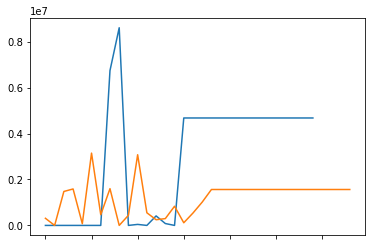

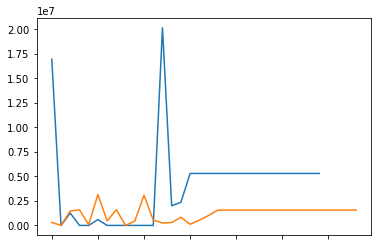

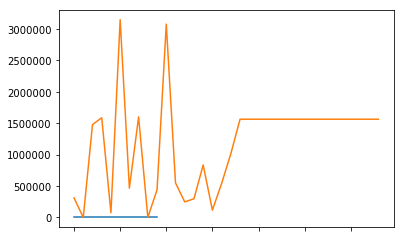

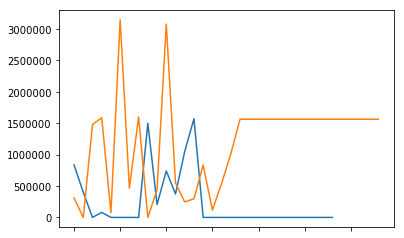

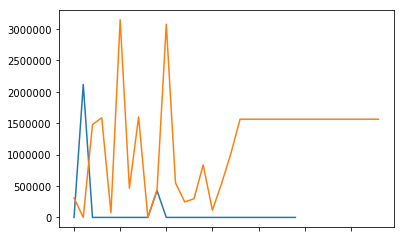

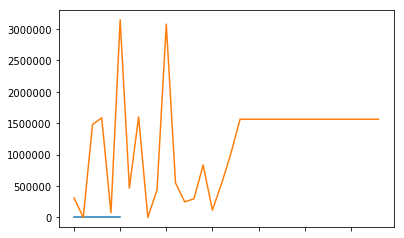

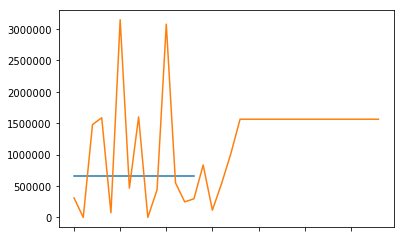

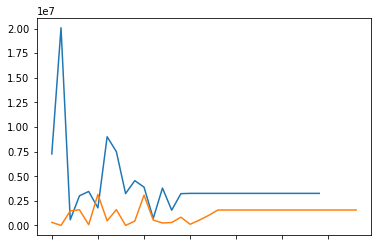

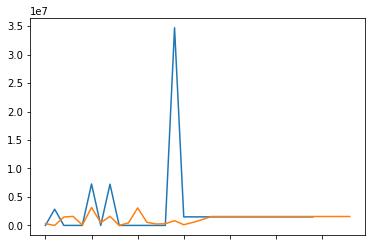

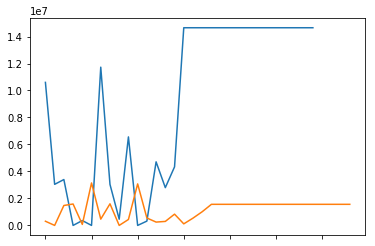

In [177]:
tar_columns = [
    "target", "null",
    'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
    '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
    'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
    '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
    'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
    '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
    '6619d81fc', '1db387535'
]

for i in range(10):
    train.loc[1383, path_collection[i]].plot()
    train.loc[1383, tar_columns].plot()
    plt.show()

In [94]:
dup = pairs_df.lnode.value_counts()


dup[dup == 1].shape

(2204,)

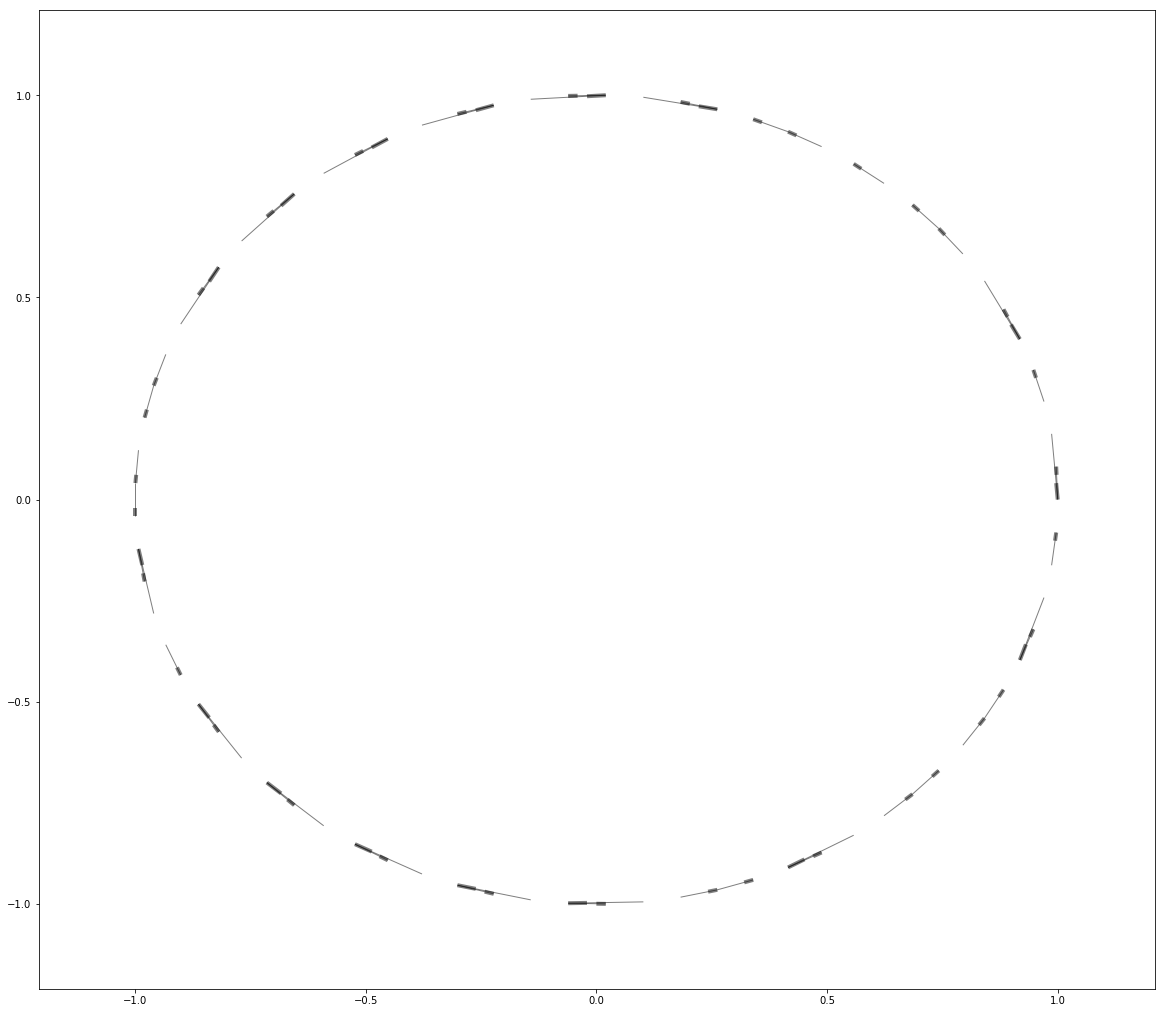

In [137]:
graph = nx.DiGraph()

graph.add_edges_from(middle_df.values[:50])

plt.figure(figsize=(20, 18))
pos=nx.circular_layout(graph)
nx.draw_networkx_edges(graph, pos, alpha=.5)
# nx.draw_networkx_labels(graph, pos, font_size=25)
plt.show()

In [75]:
rows2 = [2072, 3493, 379, 2972, 2367, 4415, 2791, 3980, 194, 1190, 3517, 811, 4444, 3698, 236, 1383]

In [63]:
rows = [1383, 2071, 3492, 378, 2971, 2366, 4414, 2790, 3979, 193, 1189, 3516, 810, 4443, 3697, 235, 1382]
columns = [
    "target", "null",
    'f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
    '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
    'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
    '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
    'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
    '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
    '6619d81fc', '1db387535'
]
mark = train.loc[rows, "f190486d6"].values[1:]

for col_ in train.columns:
    if col_ in columns:
        continue
    if col_ == "ID":
        continue
    if (train.loc[rows[:-1], col_].values == mark).sum() == len(rows[:-1]):
        print(col_)

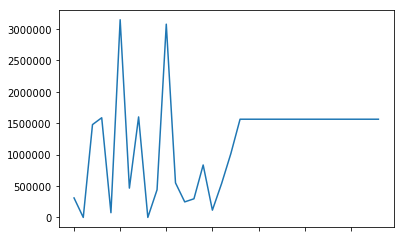

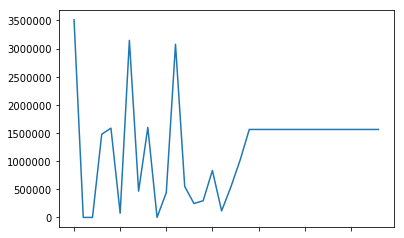

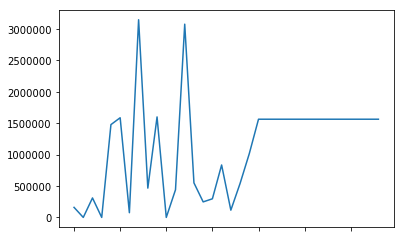

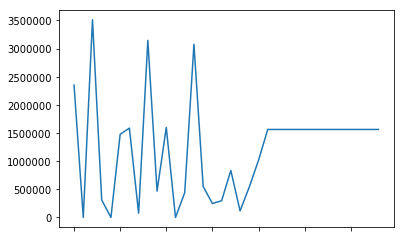

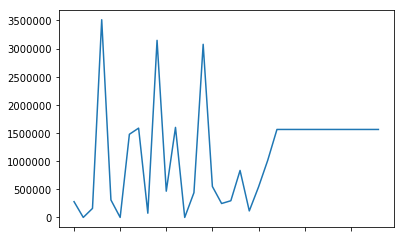

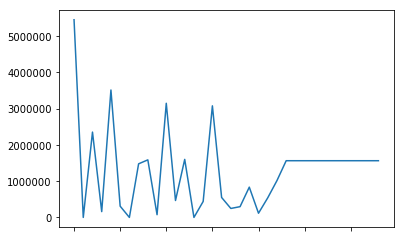

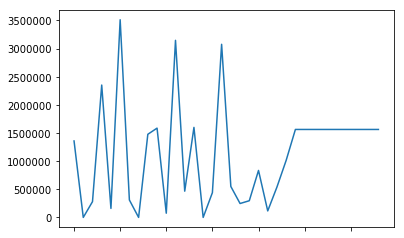

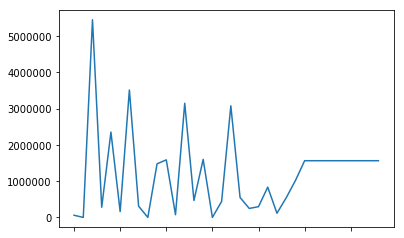

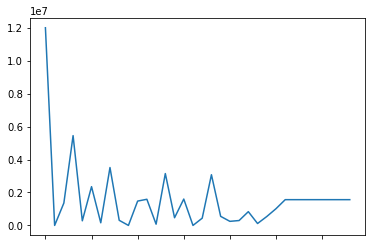

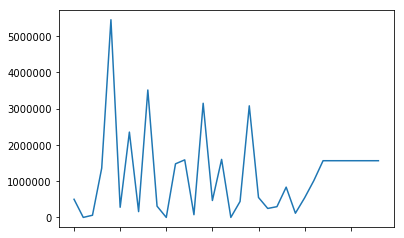

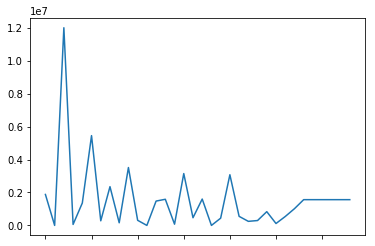

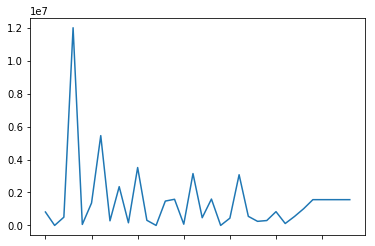

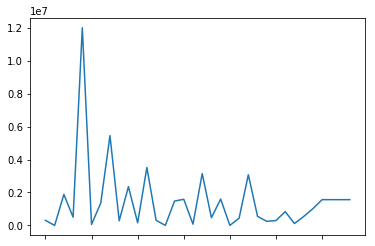

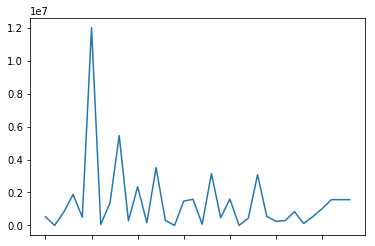

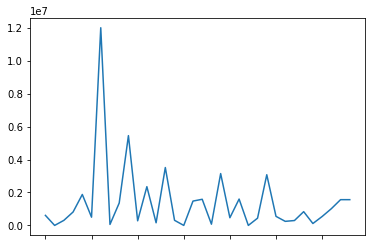

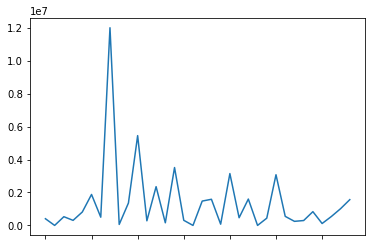

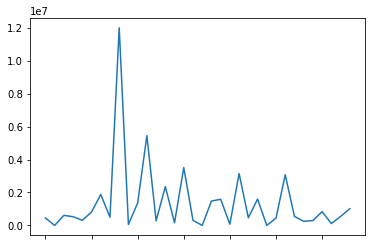

In [46]:
for row_id in [1383, 2071, 3492, 378, 2971, 2366, 4414, 2790, 3979, 193, 1189, 3516, 810, 4443, 3697, 235, 1382]:
    train.loc[row_id, columns].plot()
    plt.show()

## pred ??

In [12]:
features = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', 
            '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 
            'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
            '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 
            'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
            '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
            '6619d81fc', '1db387535']

train[features[:-2]].head()

,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,...,f74e8f13d,5c6487af1,963a49cdc,26fc93eb7,1931ccfdd,703885424,70feb1494,491b9ee45,23310aa6f,e176a204a
0,1866666.625,12066667.0,700000.0,600000.0,900000.0,4100000.0,0.0,0.0,0.0,0.0,...,1733333.375,0.0,13200000.0,3205000.0,2000000.0,0.0,1200000.0,0.0,0.0,0.0
1,0.000,2850000.0,2225000.0,1800000.0,800000.0,0.0,0.0,3300000.0,2200000.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.0,0.0,0.0,0.0,0.0,0.0,6000000.0,0.0,0.0,...,0.000,0.0,12000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000000.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000,0.0,0.0,0.0,37662000.0,0.0,4000000.0,6700000.0,2000000.0,5400000.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
d1 = train[features[:-2]].apply(tuple, axis=1).to_frame().rename(columns={0: 'key'})
d1.head()

,key
0,"(1866666.625, 12066667.0, 700000.0, 600000.0, ..."
1,"(0.0, 2850000.0, 2225000.0, 1800000.0, 800000...."
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6000000.0,..."
3,"(2000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"(0.0, 0.0, 0.0, 0.0, 37662000.0, 0.0, 4000000...."


In [26]:
d2 = train[features[2:]].apply(tuple, axis=1).to_frame().rename(columns={0: 'key'})
d2['pred'] = train[features[0]]
d2.head()

,key,pred
0,"(700000.0, 600000.0, 900000.0, 4100000.0, 0.0,...",1866666.625
1,"(2225000.0, 1800000.0, 800000.0, 0.0, 0.0, 330...",0.000
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 6000000.0, 0.0, 0.0,...",0.000
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000000.000
4,"(0.0, 0.0, 37662000.0, 0.0, 4000000.0, 6700000...",0.000


In [27]:
d2 = d2[d2['pred'] != 0]
print(d2.shape)
d2.head()

(1544, 2)


,key,pred
0,"(700000.0, 600000.0, 900000.0, 4100000.0, 0.0,...",1866666.625
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000000.000
6,"(0.0, 30000.0, 0.0, 0.0, 0.0, 4000.0, 0.0, 200...",10000.000
8,"(4000000.0, 0.0, 0.0, 0.0, 58000.0, 58000.0, 5...",3333333.250
9,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7500000.000


In [28]:
d3 = d2[~d2.duplicated(['key'], keep='first')]
print(d3.shape)
d3.head()

(1480, 2)


,key,pred
0,"(700000.0, 600000.0, 900000.0, 4100000.0, 0.0,...",1866666.625
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000000.000
6,"(0.0, 30000.0, 0.0, 0.0, 0.0, 4000.0, 0.0, 200...",10000.000
8,"(4000000.0, 0.0, 0.0, 0.0, 58000.0, 58000.0, 5...",3333333.250
9,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7500000.000


In [32]:
d = d1.merge(d3, how='left', on='key')
print(d.shape)
print(d.pred.isnull().sum())
d.head()

(4459, 2)
2711


,key,pred
0,"(1866666.625, 12066667.0, 700000.0, 600000.0, ...",38000000.0
1,"(0.0, 2850000.0, 2225000.0, 1800000.0, 800000....",600000.0
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6000000.0,...",NaN
3,"(2000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN
4,"(0.0, 0.0, 0.0, 0.0, 37662000.0, 0.0, 4000000....",NaN


In [9]:
get_log_pred(train)

0       17.453096
1       13.304687
2        0.000000
3        0.000000
4        0.000000
5        0.000000
6        0.000000
7       13.304687
8       13.794288
9        0.000000
10       0.000000
11       0.000000
12       0.000000
13      15.761421
14      14.508658
15       0.000000
16       0.000000
17      15.096445
18      14.840117
19       0.000000
20       0.000000
21      14.999281
22       0.000000
23      16.515932
24      14.508658
25       0.000000
26       0.000000
27       0.000000
28       0.000000
29      15.201805
          ...    
4429    13.880050
4430     0.000000
4431    16.811243
4432     0.000000
4433    14.603969
4434     0.000000
4435     0.000000
4436     0.000000
4437     0.000000
4438     0.000000
4439     0.000000
4440     0.000000
4441     0.000000
4442     0.000000
4443    13.178115
4444     0.000000
4445     0.000000
4446     0.000000
4447     0.000000
4448     0.000000
4449     0.000000
4450     0.000000
4451     0.000000
4452     0.000000
4453     0